# Расчет и анализ метрик  Яндекс.Афиши

Целью проекта является изучение поведения клиентов, расчет и анализ получаемой прибыли  и окупаемости их привлечения, с помощью основных продуктовых и маркетинговых метрик, а также метрик электронной коммерции.  
В качестве данных для проведения необходимых расчетов используются файлы: visits_log.csv хранит лог сервера с информацией о посещениях сайта, orders_log.csv — информацию о заказах, а costs.csv — информацию о расходах на маркетинг.  
В конце проекта сформулируем выводы и рекомендации.


## Загрузка и подготовка данных
<a id = "open_data"></a>

### Импорт библиотек и загрузка данных

In [1]:
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
from pandas.plotting import register_matplotlib_converters
import seaborn as sns

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

### Ознакомление с данными

In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [4]:
visits.duplicated().value_counts()

False    359400
dtype: int64

In [5]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [7]:
orders.duplicated().value_counts()

False    50415
dtype: int64

In [8]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [9]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [10]:
costs.duplicated().value_counts()

False    2542
dtype: int64

In [11]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


### Редактирование названий столбцов

Заменим пробелы в названиях столбцов на нижние подчеркивания и приведем к нижнему регистру

In [12]:
for data in [visits, orders]:
    
    data.columns = [x.lower().replace(' ', '_') for x in data.columns]

In [13]:
visits.head()

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


### Изменение типа данных
<a id = "type"></a>

Изменим тип данных в столбцах с датами на datetime64

In [14]:
visits.loc[:, ['end_ts', 'start_ts']] = visits.loc[:, ['end_ts', 'start_ts']].astype('datetime64')
orders['buy_ts'] = orders['buy_ts'].astype('datetime64')
costs['dt'] = costs['dt'].astype('datetime64')

## Расчет метрик и визуализация
<a id = "viz"></a>

### Продуктовые метрики
<a id = "prod"></a>

#### Рассчет DAU, WAU и MAU. Вычисление средних значений этих метрик за весь период. Отображение изменения метрик во времени на графиках

In [15]:
visits['session_year']  = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].dt.month
visits['session_week']  = visits['start_ts'].dt.week
visits['session_date'] = visits['start_ts'].dt.date

In [16]:
dau_mean = int((visits.groupby(['session_date']).agg({'uid' : 'nunique'}).mean()))

wau_mean = int((visits.groupby(['session_year', 'session_week']).agg({'uid' : 'nunique'}).mean()))

mau_mean = int((visits.groupby(['session_year', 'session_month']).agg({'uid' : 'nunique'}).mean()))

In [17]:
au_mean = pd.DataFrame({'metric' : ['DAU', 'WAU', 'MAU'], 'mean' : [dau_mean, wau_mean, mau_mean]})
au_mean

,metric,mean
0,DAU,907
1,WAU,5716
2,MAU,23228


In [18]:
dau = (visits.copy().groupby(['session_date']).agg({'uid' : 'nunique'})).reset_index()

wau = (visits.copy().groupby(['session_year', 'session_week']).agg({'uid' : 'nunique'}))

mau = (visits.copy().groupby(['session_year', 'session_month']).agg({'uid' : 'nunique'}))

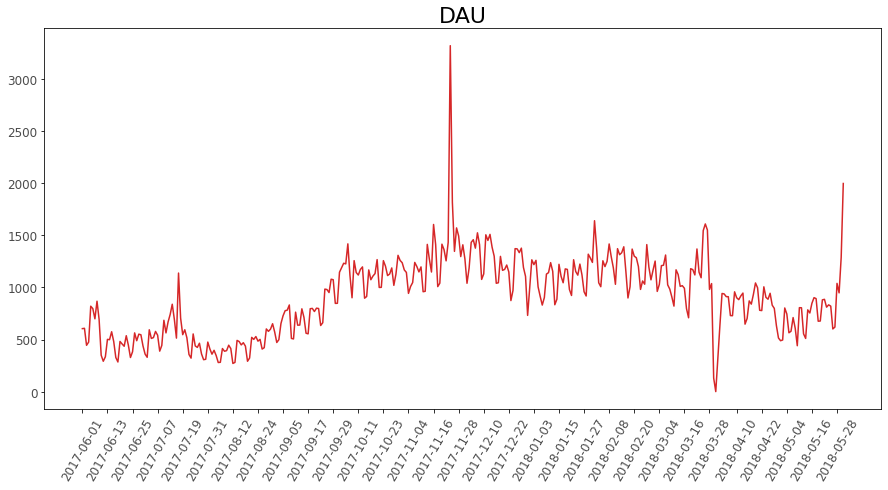

In [19]:
register_matplotlib_converters()
plt.figure(figsize=(15,7))
plt.plot('session_date', 'uid', data=dau, color='tab:red')

xtick_location = dau.session_date.tolist()[::12]
plt.xticks(ticks=xtick_location, rotation=60, fontsize=12, horizontalalignment='center', alpha=.7)
plt.yticks(fontsize=12, alpha=.7)
plt.title('DAU', fontsize=22)

plt.show()

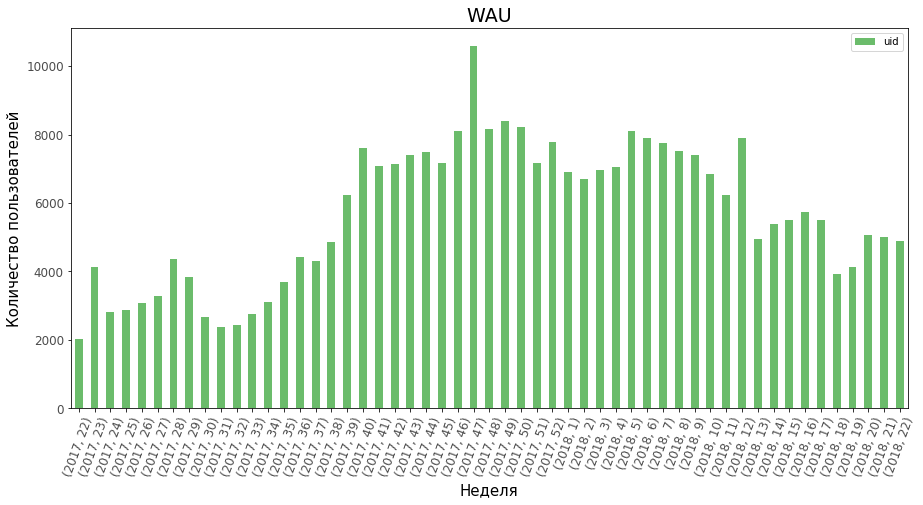

In [20]:
wau.plot.bar(color='tab:green', figsize=(15,7), alpha=.7)

plt.xticks(rotation=70, fontsize=12, horizontalalignment='center', alpha=.7)
plt.yticks(fontsize=12, alpha=.7)
plt.xlabel('Неделя', fontsize=15)
plt.ylabel('Количество пользователей', fontsize=15)
plt.title('WAU', fontsize=19)

plt.show()

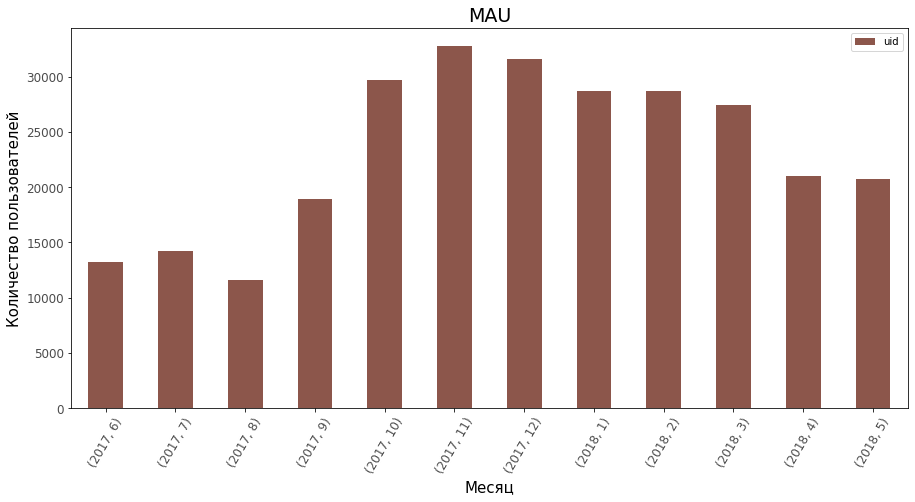

In [21]:
mau.plot.bar(color='tab:brown', figsize=(15,7))

plt.xticks(rotation=60, fontsize=12, horizontalalignment='center', alpha=.7)
plt.yticks(fontsize=12, alpha=.7)
plt.xlabel('Месяц', fontsize=15)
plt.ylabel('Количество пользователей', fontsize=15)
plt.title('MAU', fontsize=19)

plt.show()

Повышенная активность пользователей наблюдается во второй половине ноября 2017 года.

#### Определение среднего значения количества дневных посещений сайта пользователями. Построение графика, отражающего изменения метрики во времени

In [22]:
day_visits = visits.copy().groupby(['session_date'])['uid'].count().reset_index()
day_visits_mean = int(day_visits['uid'].mean())
day_visits_mean

987

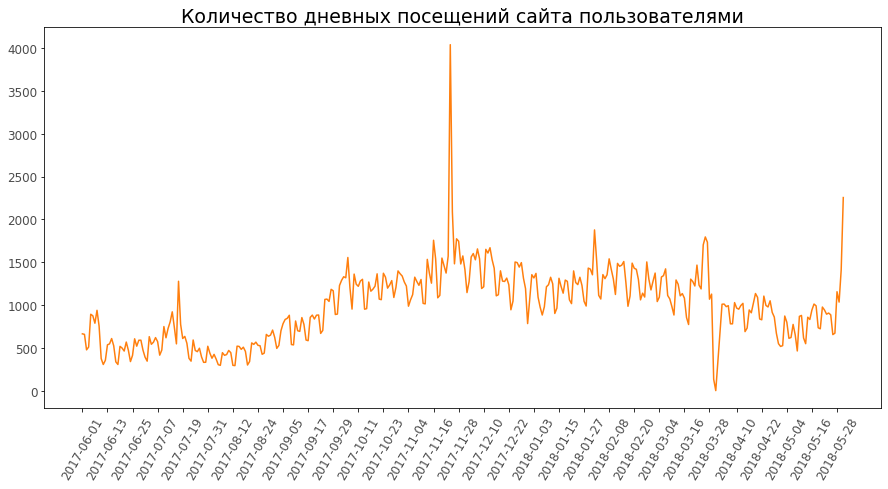

In [23]:
plt.figure(figsize=(15,7))
plt.plot('session_date', 'uid', data=day_visits, color='tab:orange')

xtick_location = day_visits.session_date.tolist()[::12]
plt.xticks(ticks=xtick_location, rotation=60, fontsize=12, horizontalalignment='center', alpha=.7)
plt.yticks(fontsize=12, alpha=.7)
plt.title('Количество дневных посещений сайта пользователями', fontsize=19)

plt.show()

График количества дневных посещений сайта пользователями и график метрики DAU коррелируют с небольшим смещением по оси y относительно друг друга. Диапазон смещения зависит от количества пользователей, неоднократно посетивших сайт.  

Также наблюдается повышенное количество посещений в конце ноября.  

В среднем 987 раз в день пользователи заходят на сайт.

#### Исследование количества времени, проведенного пользователями на сайте. Расчет продолжительности типичной пользовательской сессии за весь период. Построение графика распределения.

In [24]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds


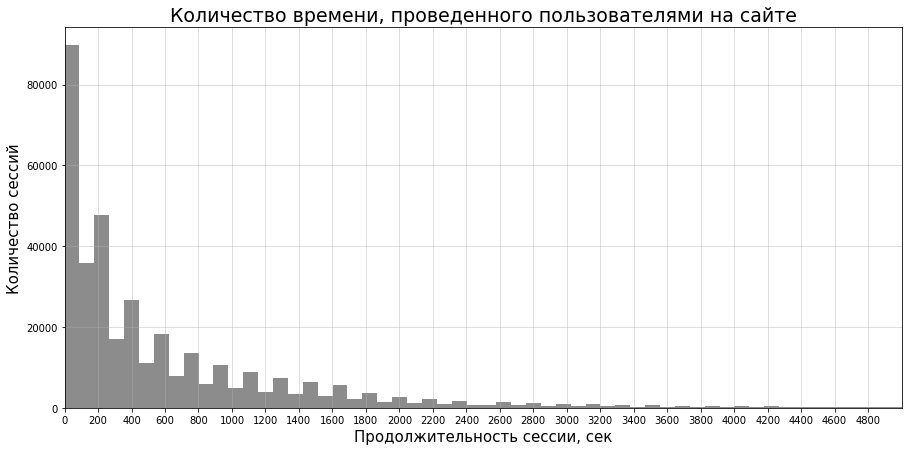

In [25]:
visits['session_duration_sec'].plot.hist(bins=950, xlim=(0,5000), figsize=(15,7), facecolor='gray', alpha=.9)

plt.xticks(range(0, 5000, 200))
plt.grid(True, alpha=.5)
plt.title('Количество времени, проведенного пользователями на сайте', fontsize=19)
plt.xlabel('Продолжительность сессии, сек', fontsize=15)
plt.ylabel('Количество сессий', fontsize=15)

plt.show()

На гистограмме видно что  продолжительность наибольшего количества сессий составляет менее 100 секунд.

In [26]:
ASL = (visits['session_duration_sec'].mode())[0]
print(f'\033[1m{"Продолжительность типичной пользовательской сессии за весь период в секундах: "}\033[0m{ASL}')

Продолжительность типичной пользовательской сессии за весь период в секундах: 60


#### Рассчет Retention Rate с применением когортного анализа. Визуализация изменения метрики во времени. Расчет среднего значения Retention Rate на второй месяц «жизни» когорт.

Создадим столбцы с первым месяцем посещения и с месяцем сессии. Сгруппируем когорты по первому месяцу посещения.

In [27]:
first_visit = visits.copy().groupby(['uid'])['start_ts'].min()
first_visit.name = 'first_visit'
visits_new = visits.copy().join(first_visit, on='uid')

visits_new['first_visit_month'] = visits_new['first_visit'].astype('datetime64[M]')
visits_new['session_month'] = visits_new['start_ts'].astype('datetime64[M]')

cohorts = visits_new.groupby(['first_visit_month', 'session_month']).agg({'uid' : 'nunique'})
cohorts = cohorts.reset_index()

Вычислим lifetime и приведем данные к строковому типу, оставив только год и месяц.

In [28]:
cohorts['cohort_lifetime'] = (cohorts['session_month'] - cohorts['first_visit_month'])

cohorts['cohort_lifetime'] = (cohorts['cohort_lifetime'] / np.timedelta64(1, 'M')).round().astype('int')

cohorts['first_visit_month'] = (cohorts['first_visit_month'].dt.strftime('%Y-%m'))

Добавим к таблице столбец с начальным количеством пользователей для каждой когорты.

In [29]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visit_month', 'uid']]

initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})

In [30]:
cohorts = cohorts.merge(initial_users_count, on='first_visit_month')

Посчитаем Retention rate и добавим столбец с соответствующим значением.

In [31]:
cohorts['retention_rate'] = cohorts['uid'] / cohorts['cohort_users']

Построим сводную таблицу, сгруппировав данные по когортам и создадим тепловую карту.

In [32]:
retention_pivot = cohorts.pivot_table(
    index='first_visit_month',
    columns='cohort_lifetime',
    values='retention_rate',
    aggfunc='sum'
) 

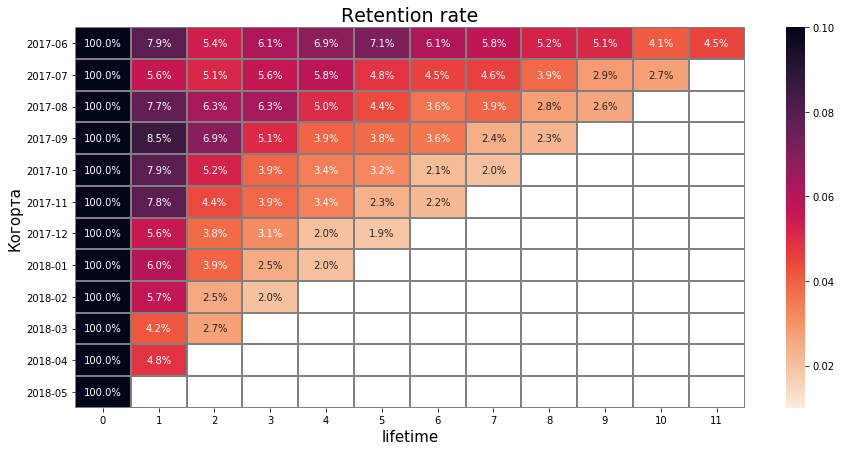

In [33]:
plt.figure(figsize=(15,7))
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray'
            , cmap='rocket_r', vmax=0.10, vmin=0.01)

plt.title('Retention rate', fontsize=19)
plt.xlabel('lifetime', fontsize=15)
plt.ylabel('Когорта', fontsize=15)

plt.show()

Рассчитаем среднее значение Retention Rate на второй месяц «жизни» когорт

In [34]:
rr_mean = cohorts[cohorts['cohort_lifetime'] == 1]['retention_rate'].mean() * 100
rr_mean.round(2)

6.52

Лишь 6.52% пользователей в среднем возвращаются на сайт в следующем месяце после первого посещения.

### Метрики электронной коммерции

#### Исследование среднего количества времени с момента первого посещения сайта до совершения покупки

Для вычисления метрик создадим таблицу с данными о первом визите и первой покупке для каждого пользователя, совершившего покупку

In [35]:
first_visit = visits.copy().groupby('uid').agg({'start_ts' : 'min'}).reset_index()
first_order = orders.copy().groupby('uid').agg({'buy_ts' : 'min'}).reset_index()

In [36]:
buyers = first_visit.merge(first_order, on='uid')

Рассчитаем разницу во времени между первой покупкой и первым визитом, переведем в минуты и вычислим среднее значение.

In [37]:
buyers['first_buy_delta'] = buyers['buy_ts'] - buyers['start_ts']
buyers['first_buy_delta'] = (buyers['first_buy_delta'] / np.timedelta64(1, 'm')).round().astype('Int64')


In [38]:
buyers['first_buy_delta'].describe()

count     36523.000000
mean      24340.175834
std       67784.774690
min           0.000000
25%           4.000000
50%          16.000000
75%        2897.000000
max      523144.000000
Name: first_buy_delta, dtype: float64

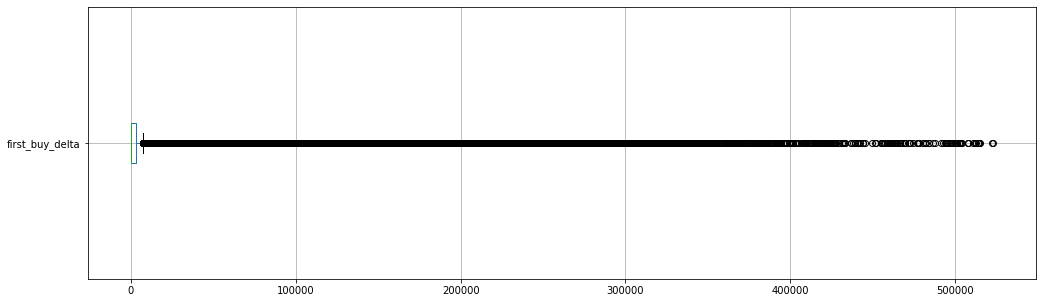

In [39]:

buyers.boxplot(column=['first_buy_delta'], vert=False, figsize=(17, 5))
plt.show()

Отбросим нулевые и экстремально высокие значения

In [40]:
Q1 =  buyers['first_buy_delta'].quantile(0.25)
Q3 = buyers['first_buy_delta'].quantile(0.75)
IQR = Q3 - Q1
buyers_time = buyers[(buyers['first_buy_delta'] != 0) & (buyers['first_buy_delta'] < Q3+1.5*IQR)]

buyers_time['first_buy_delta'].describe()

count    26259.000000
mean       401.415667
std       1152.756504
min          1.000000
25%          4.000000
50%         10.000000
75%         49.000000
max       7235.000000
Name: first_buy_delta, dtype: float64

Если ориентироваться на рассчитанное среднее значение, то с момента первого посещения сайта до первой покупки проходит 401 минута, почти 7 часов!  
Но если посмотреть на процентили, то видно, что пользователи в основном совершают покупку в течении часа после первого посещения, а половина из них укладывается в 10 минут!

#### Расчет среднего количества покупок на одного покупателя за период

Создадим функцию, высчитывающую среднее количество покупок на покупателя за указанный период.

In [41]:
def mean_orders_per_user(df, col_id, col_dt, start_dt, end_dt):
    
    orders = df.loc[(start_dt <= df[col_dt]) & (df[col_dt] < end_dt), :].copy()
    orders_count = orders.groupby(col_id).agg({col_dt : 'count'}).reset_index()
    mean_result = orders_count[col_dt].mean().round(2)
    
    return mean_result

In [42]:
orders['buy_ts'].describe()

count                   50415
unique                  45991
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-06-01 00:02:00
Name: buy_ts, dtype: object

Данные о покупках у нас есть за год. Расссчитаем среднее количество покупок на покупателя по временам года, а также за весь период.

In [43]:
summer = mean_orders_per_user(orders, 'uid', 'buy_ts', '2017-06-01', '2017-09-01')
autumn = mean_orders_per_user(orders, 'uid',  'buy_ts','2017-09-01', '2017-12-01')
winter = mean_orders_per_user(orders, 'uid',  'buy_ts','2017-12-01', '2018-03-01')
spring = mean_orders_per_user(orders, 'uid',  'buy_ts','2018-03-01', '2018-06-01')
total = mean_orders_per_user(orders, 'uid',  'buy_ts','2017-06-01', '2018-06-01')

In [44]:
mean_orders_df = pd.DataFrame({'период' : ['лето', 'осень', 'зима', 'весна', 'год']
                            ,'среднее количество покупок на покупателя' : [summer, autumn, winter, spring, total]})
mean_orders_df

,период,среднее количество покупок на покупателя
0,лето,1.23
1,осень,1.29
2,зима,1.30
3,весна,1.29
4,год,1.38


В течении всего периода значение среднего количества покупок на покупателя практически не изменяется, но заметно небольшое снижение показателя в летний период.

#### Рассчет среднего чека с  группировкой по времени совершения покупки. Визуализация изменения метрики во времени

Сгруппируем таблицу с данными о покупках по дате их совершения, суммируем выручку и подсчитаем количество покупок.

In [45]:
orders_grouped = orders.copy().groupby(orders['buy_ts'].dt.date).agg({'revenue' : 'sum', 'uid' : 'count'}).reset_index()
orders_grouped = orders_grouped.rename({'uid' : 'orders_cnt'}, axis=1)

Найдем средний чек по каждому дню, поделив сумму выручки на количество покупок.

In [46]:
orders_grouped['avg_check'] = (orders_grouped['revenue'] / orders_grouped['orders_cnt']).round(2)

In [47]:
orders_grouped['avg_check'].describe()

count    364.000000
mean       4.936236
std        2.021761
min        1.950000
25%        3.960000
50%        4.560000
75%        5.410000
max       29.130000
Name: avg_check, dtype: float64

In [48]:
mean_check = orders_grouped['avg_check'].mean().round(1)
print(f'\033[1m{"Cредний чек за весь период: "}\033[0m{mean_check}')

Cредний чек за весь период: 4.9


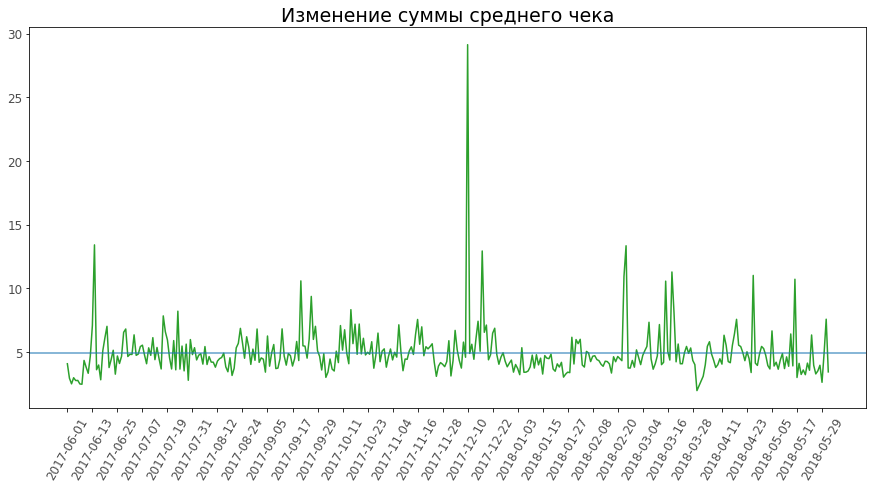

In [49]:
plt.figure(figsize=(15,7))

plt.plot('buy_ts', 'avg_check', data=orders_grouped, color='tab:green')
plt.axhline(y=mean_check, alpha=0.7, label='Среднее значение за весь период')

xtick_location = orders_grouped.buy_ts.tolist()[::12]
plt.xticks(ticks=xtick_location, rotation=60, fontsize=12, horizontalalignment='center', alpha=.7)
plt.yticks(fontsize=12, alpha=.7)
plt.title('Изменение суммы среднего чека', fontsize=19)

plt.show()

Значения среднедневного чека в основном находятся в диапазоне от 2 до 6 у.е. с периодическим повышением в диапазон 10-15. Максимальное значние зафиксировано в первой половине декабря и составляет 29 у.е.

#### Анализ изменения LTV на покупателя по когортам. Рассчет среднего LTV по когортам за 6 месяцев при маржинальности сервиса — 100%. Визуализация изменения метрики во времени

Вычислим месяц первой покупки каждого покупателя и посчитаем количество новых покупателей за каждый месяц.

In [50]:
orders['purchase_month'] = orders['buy_ts'].astype('datetime64[M]')

first_purchases = orders.copy().groupby('uid').agg({'purchase_month': 'min'}).reset_index()
first_purchases.columns = ['uid', 'first_purchase_month']

cohort_sizes = first_purchases.groupby('first_purchase_month').agg({'uid': 'nunique'}).reset_index()

cohort_sizes.columns = ['first_purchase_month', 'buyers_cnt']

Сформируем когорты.  
Добавим месяц первой покупки каждого покупателя в таблицу с покупками и сгруппируем таблицу покупок по месяцу первой покупки и месяцу каждой покупки, сложив выручку.

In [51]:
orders_new = pd.merge(orders.copy(),first_purchases, on='uid')

purchases_cohorts = (orders_new.groupby(['first_purchase_month', 'purchase_month'])
                     .agg({'revenue': 'sum'})
                     .reset_index()
                    )

Добавим в таблицу с когортами данные о том, сколько людей первый раз совершили покупку в каждый месяц.

In [52]:
report = pd.merge(cohort_sizes, purchases_cohorts, on='first_purchase_month')

In [53]:
margin_rate = 1

report['gross_profit'] = report['revenue'] * margin_rate

report['lifetime'] = (report['purchase_month'] - report['first_purchase_month']) / np.timedelta64(1, 'M')
report['lifetime'] = report['lifetime'].round().astype('int')
report['first_purchase_month'] = (report['first_purchase_month'].dt.strftime('%Y-%m'))

Посчитаем LTV.  
Разделим валовую прибыль когорт за каждый месяц на общее число пользователей в каждой когорте

In [54]:
report['ltv'] = report['gross_profit'] / report['buyers_cnt']

Построим сводную таблицу и вычислим средний LTV по когортам за 6 месяцев.

In [55]:
result = report.pivot_table(index='first_purchase_month', columns='lifetime', values='ltv', aggfunc='mean')

In [56]:
m6_cum_ltv = result.cumsum(axis=1).mean(axis=0)[5].round(2)
print(f'\033[1m{"Cредний LTV по когортам за 6 месяцев: "}\033[0m{m6_cum_ltv}')

Cредний LTV по когортам за 6 месяцев: 7.97


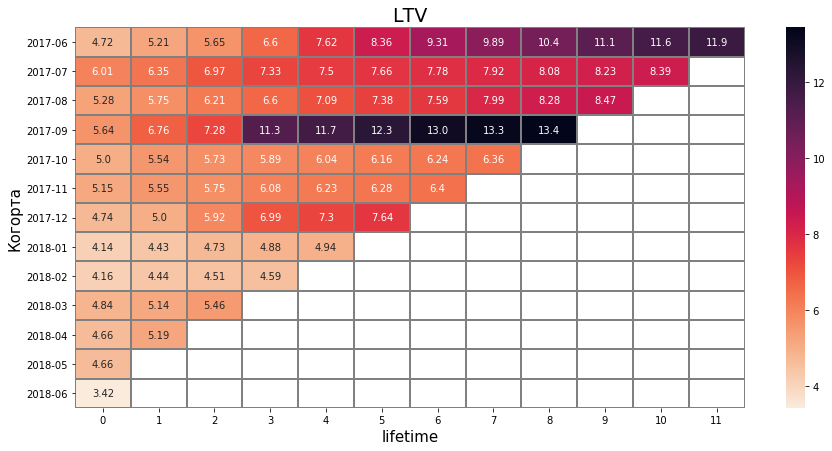

In [57]:
plt.figure(figsize=(15,7))
sns.heatmap(result.cumsum(axis=1), annot=True, fmt='.3', linewidths=1, linecolor='gray', cmap='rocket_r')
plt.title('LTV', fontsize=19)
plt.xlabel('lifetime', fontsize=15)
plt.ylabel('Когорта', fontsize=15)

plt.show()

На полученной тепловой карте можно заметить резкий рост LTV в сентябрьской когорте на 4й месяц. Это как раз декабрь, отмеченный ранее резким скачком суммы среднего чека.

###  Маркетинговые метрики

#### Расчет общей суммы расходов на маркетинг. Исследование распределения трат по источникам. Визуализация изменения метрик во времени

Рассчитаем общую сумму расходов на маркетинг.

In [58]:
total_costs = costs['costs'].sum()
print(f'\033[1m{"Общая сумма расходов на маркетинг: "}\033[0m{total_costs}')

Общая сумма расходов на маркетинг: 329131.62


Рассчитаем распределение трат по источникам.

In [59]:
costs_by_source = (costs.pivot_table(index='source_id', values='costs', aggfunc='sum')
                   .sort_values(by='costs', ascending=False)
                  )

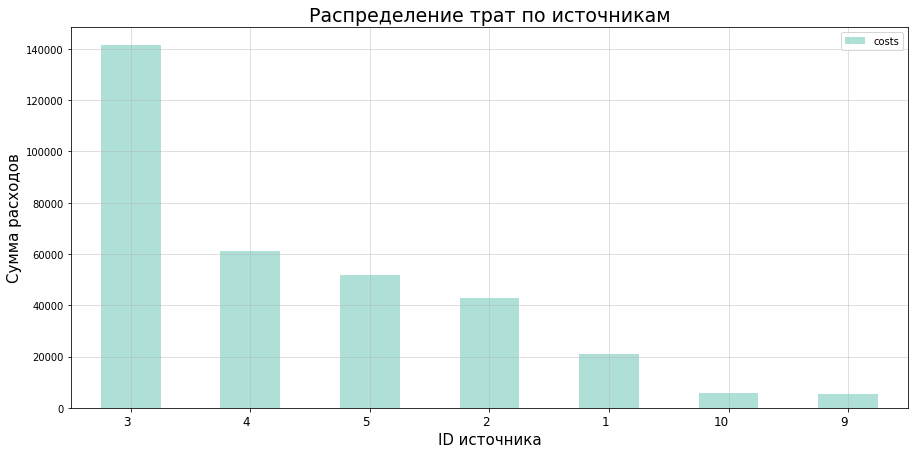

In [60]:
costs_by_source.plot(kind='bar', figsize=(15,7), colormap='Set3', alpha=0.7)

plt.xticks(rotation=0, horizontalalignment='right', fontsize=12)
plt.grid(True, alpha=.5)
plt.title('Распределение трат по источникам', fontsize=19)
plt.xlabel('ID источника', fontsize=15)
plt.ylabel('Сумма расходов', fontsize=15)

plt.show()

In [61]:
costs_per_month = (costs.pivot_table(index=costs['dt'].astype('datetime64[M]'), columns='source_id'
                                     , values='costs', aggfunc='sum')
                  )

In [62]:
costs_per_month = costs_per_month.rename_axis([None], axis=0)
costs_per_month = costs_per_month.rename_axis([None], axis=1).reset_index()
costs_per_month = costs_per_month.rename({'index' : 'date'}, axis=1)
costs_per_month.columns = costs_per_month.columns.astype('str')

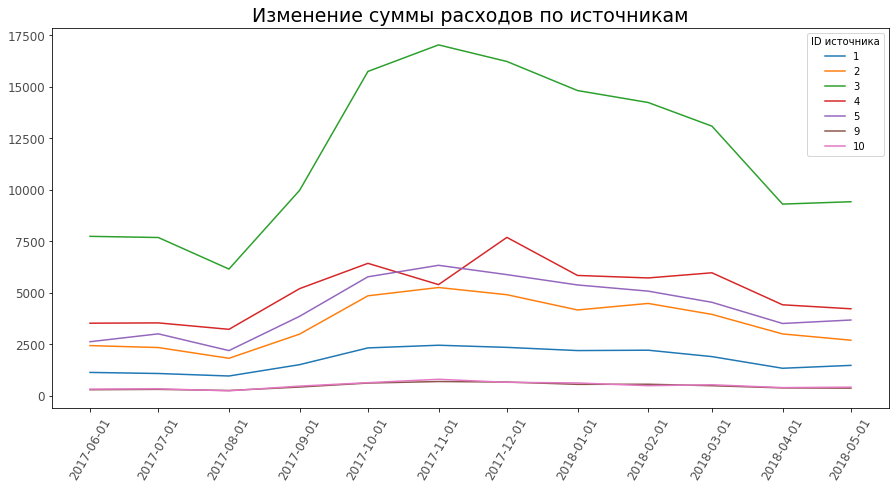

In [63]:
fig, ax = plt.subplots(figsize=(15,7), facecolor='white') 

columns = costs_per_month.columns[1:]

for col in columns:
    ax.plot(costs_per_month['date'], costs_per_month[col], label=col)

ax.legend(title="ID источника")   
xtick_location = costs_per_month.date.tolist()[::]
plt.xticks(ticks=xtick_location, rotation=60, fontsize=12, horizontalalignment='center', alpha=.7)
plt.yticks(fontsize=12, alpha=.7)
plt.title('Изменение суммы расходов по источникам', fontsize=19)

plt.show()

Больше всего расходов приходится на источники 3, 4 и 5. Выделяется сильный рост трат на источник 3 с августа по ноябрь.

#### Рассчет среднего CAC на одного покупателя для всего проекта и для каждого источника трафика. Визуализация изменения метрик

Сгруппируем таблицы с посещениями и покупками по уникальным идентификаторам пользователей и дате.  В таблице с посещениями у пользователей, которые приходили с нескольких источников, оставим только те, с которых они пришли впервые.  

Таблицу с расходами сгруппируем по идентификаторам рекламного источника и месяцу.

In [64]:
visits_grouped_by_uid = visits.copy().groupby(['uid', 'source_id', 'start_ts'])['device'].count().reset_index()
visits_grouped_by_uid = visits_grouped_by_uid.sort_values(by='start_ts').drop_duplicates('uid', keep='first')
visits_grouped_by_uid = visits_grouped_by_uid.drop('device', 1)

orders_grouped_by_uid = orders.copy().groupby(['uid', 'purchase_month']).agg({'revenue' : 'sum', 'buy_ts' : 'min'}).reset_index()

costs_grouped_by_source_id = (costs.groupby(['source_id', costs['dt'].astype('datetime64[M]')])
                              .agg({'costs' : 'sum'})
                              .reset_index()
                             )

In [65]:
costs_grouped_by_source_id = costs_grouped_by_source_id.rename({'dt' : 'date'}, axis=1)

Соединим полученные таблицы с посещениями и покупками по 'uid', чтобы у покупателей появился идентификатор рекламного источника.

In [66]:
buyers_with_source_id = visits_grouped_by_uid.merge(orders_grouped_by_uid, on='uid', how='right')
buyers_with_source_id = buyers_with_source_id.rename({'buy_ts' : 'date'}, axis=1)
buyers_with_source_id['date'] = buyers_with_source_id['date'].astype('datetime64[M]')

Сгруппируем данную таблицу по идентификатору рекламного источника и дате первой покупки, рассчитав количество уникальных покупателей.

In [67]:
buyers_grouped = buyers_with_source_id.groupby(['source_id','date']).agg({'uid' : 'count'}).reset_index()

buyers_grouped = buyers_grouped.rename({'uid' : 'new_buyers'}, axis=1)


Объединим по столбцам 'source_id' и 'date'полученную таблицу с таблицей сгруппированных расходов. 

In [68]:
report_cac = costs_grouped_by_source_id.merge(buyers_grouped, on=['source_id', 'date'])


Рассчитаем САС, создав одноименный столбец.

In [69]:
report_cac['cac'] = (report_cac['costs'] / report_cac['new_buyers']).round(2)

Построим график изменения значений CAC для каждого источника, для этого сформируем сводную таблицу.

In [70]:
cac_per_month = (report_cac.pivot_table(index='date', columns='source_id'
                                     , values='cac', aggfunc='mean')
                  )

In [71]:
cac_per_month = cac_per_month.rename_axis([None], axis=0)
cac_per_month = cac_per_month.rename_axis([None], axis=1).reset_index()
cac_per_month = cac_per_month.rename({'index' : 'date'}, axis=1)
cac_per_month.columns = costs_per_month.columns.astype('str')

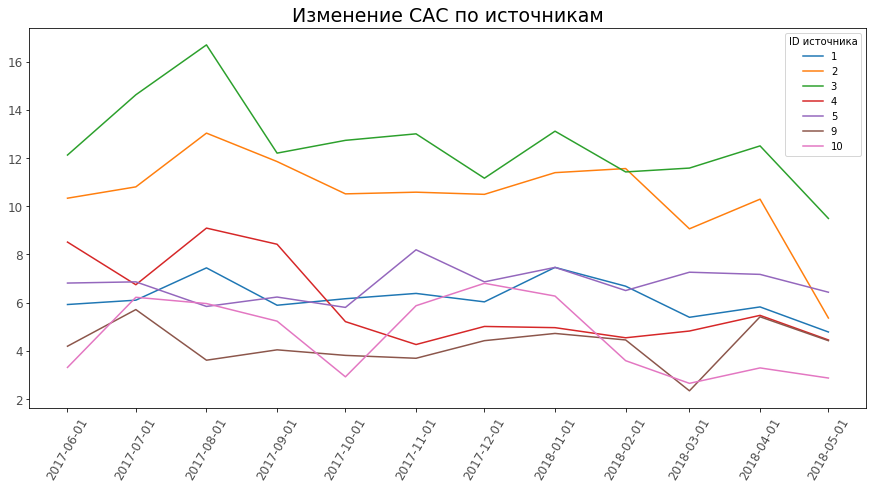

In [72]:
fig, ax = plt.subplots(figsize=(15,7), facecolor='white') 

columns = cac_per_month.columns[1:]

for col in columns:
    ax.plot(cac_per_month['date'], cac_per_month[col], label=col)

ax.legend(title="ID источника")   
xtick_location = cac_per_month.date.tolist()[::]
plt.xticks(ticks=xtick_location, rotation=60, fontsize=12, horizontalalignment='center', alpha=.7)
plt.yticks(fontsize=12, alpha=.7)
plt.title('Изменение CAC по источникам', fontsize=19)

plt.show()

Рассчитаем средний CAC на одного покупателя для всего проекта.

In [73]:
cac_total_mean = report_cac['cac'].mean().round(2)
print(f'\033[1m{"Cредний CAC на одного покупателя для всего проекта: "}\033[0m{cac_total_mean}')

Cредний CAC на одного покупателя для всего проекта: 7.25


Рассчитаем средний CAC для каждого источника трафика.

In [74]:
cac_mean_per_source = (report_cac.groupby('source_id')
                       .agg({'cac' : 'mean'})
                       .reset_index()
                       .sort_values(by='cac', ascending=False)
                      )
cac_mean_per_source['cac_mean'] = cac_mean_per_source['cac'].round(2)
cac_mean_per_source = cac_mean_per_source.drop('cac', axis=1)

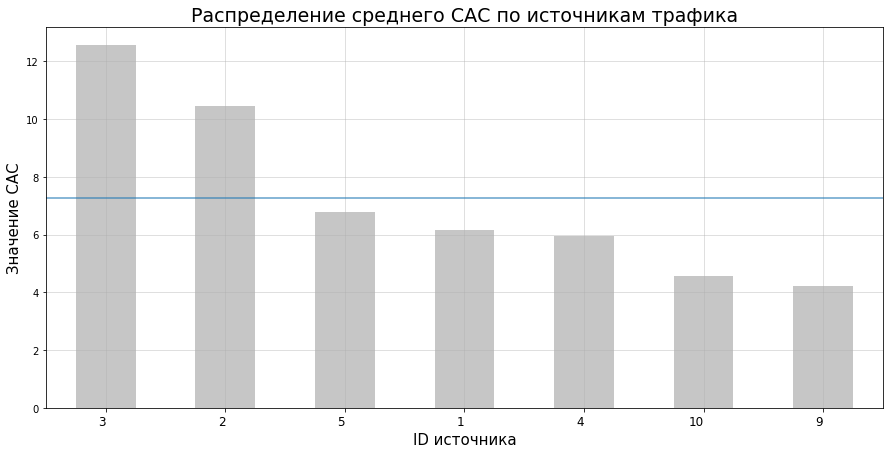

In [75]:
cac_mean_per_source.plot(kind='bar', x='source_id',  color='silver', alpha=0.9, figsize=(15, 7), legend=False)

plt.axhline(y=cac_total_mean, alpha=0.7, label='Среднее значение за весь период')

plt.xticks(rotation=0, horizontalalignment='right', fontsize=12)
plt.grid(True, alpha=.5)
plt.title('Распределение среднего CAC по источникам трафика', fontsize=19)
plt.xlabel('ID источника', fontsize=15)
plt.ylabel('Значение САС', fontsize=15)

plt.show()

Самое высокое значение САС у источника 3 и кажется оно выше LTV...(синей линией отмечено среднее значение для всего проекта)

#### Рассчет ROMI по когортам в разрезе источников. Сравнение окупаемости за одинаковые периоды жизни когорт. Визуализация изменения метрик во времени

Возьмем таблицу orders_new из предыдущего формирования кагорт и добавим к ней идентификатор источника и сгруппируем по источникам и по месяцу покупки.

In [76]:
report_buy = (orders_new.merge(visits_grouped_by_uid, on='uid').groupby(['first_purchase_month', 'source_id', 'purchase_month'])
                     .agg({'revenue': 'sum', 'uid' : 'nunique'})
                     .reset_index()
                    )

Соединим полученную таблицу с таблицей с расходами и рассчитанным ранее САС по месяцу покупки и источнику.

In [77]:
report_total = report_buy.merge(cac_mean_per_source, on='source_id')

In [78]:
report_total.head()

,first_purchase_month,source_id,purchase_month,revenue,uid,cac_mean
0,2017-06-01,1,2017-06-01,1378.70,190,6.17
1,2017-06-01,1,2017-07-01,414.98,16,6.17
2,2017-06-01,1,2017-08-01,419.43,10,6.17
3,2017-06-01,1,2017-09-01,714.24,9,6.17
4,2017-06-01,1,2017-10-01,811.20,12,6.17


Для каждого пользователя найдем источник, с которого он впервые зашел на сайт.  
Сгруппируем визиты по пользователям, источнику и для каждого источника определим дату самой первой сессии.

In [79]:
visits_source = (visits.copy().groupby(['uid', 'source_id'])['start_ts']
                       .min().reset_index()
                      )

Отсортируем таблицу по времени начала сессии по возрастанию и удалим дубликаты в столбце с пользователями, оставив только первое вхождение.

In [80]:
visits_first_source = (visits_source
                         .sort_values(by='start_ts')
                         .drop_duplicates('uid', keep='first')
                        )
visits_first_source.head()

,uid,source_id,start_ts
209422,13890188992670018146,5,2017-06-01 00:01:00
243360,16152015161748786004,3,2017-06-01 00:02:00
251926,16706502037388497502,3,2017-06-01 00:02:00
133275,8842918131297115663,3,2017-06-01 00:04:00
155911,10329302124590727494,1,2017-06-01 00:09:00


Присоединим таблицу с данными о покупках по uid.

In [81]:
orders_by_source = visits_first_source.merge(orders, on='uid')

Найдем месяц первой покупки для каждого пользователя и добавим в таблицу

In [82]:
first_orders = (orders_by_source.copy().groupby('uid')
                   .agg({'purchase_month': 'min'})
                   .reset_index()
                  )

first_orders.columns = ['uid', 'first_purchase_month']

orders_by_source_new = orders_by_source.merge(first_orders, on='uid')

In [83]:
orders_by_source_new.head()

,uid,source_id,start_ts,buy_ts,revenue,purchase_month,first_purchase_month
0,10329302124590727494,1,2017-06-01 00:09:00,2017-06-01 00:10:00,17.00,2017-06-01,2017-06-01
1,11627257723692907447,2,2017-06-01 00:14:00,2017-06-01 00:25:00,0.55,2017-06-01,2017-06-01
2,16109239769442553005,2,2017-06-01 00:14:00,2017-06-01 00:29:00,0.55,2017-06-01,2017-06-01
3,17903680561304213844,2,2017-06-01 00:25:00,2017-06-01 00:27:00,0.37,2017-06-01,2017-06-01
4,16945437833757229838,2,2017-06-01 01:18:00,2017-07-21 14:56:00,1.67,2017-07-01,2017-07-01


Сгруппируем таблицу по месяцу первой покупки, источнику и месяцу покупки, сложив выручку и подсчитав количесвто уникальных пользователей

In [84]:
res = (orders_by_source_new.groupby(['first_purchase_month', 'source_id', 'purchase_month'])
       .agg({'revenue' : 'sum', 'uid' : 'nunique'}).reset_index()
        )
res.head()

,first_purchase_month,source_id,purchase_month,revenue,uid
0,2017-06-01,1,2017-06-01,1378.70,190
1,2017-06-01,1,2017-07-01,414.98,16
2,2017-06-01,1,2017-08-01,419.43,10
3,2017-06-01,1,2017-09-01,714.24,9
4,2017-06-01,1,2017-10-01,811.20,12


Рассчитаем количество покупателей в каждой когорте и добавим в предыдущую таблицу.

In [85]:
cohorts_s = (orders_by_source_new.copy()
            .groupby(['source_id', 'first_purchase_month'])
            .agg({'uid' : 'nunique'})
            .reset_index()
           )
cohorts_s = cohorts_s.rename({'uid' : 'buyers_cnt'}, axis=1)

In [86]:
output = res.merge(cohorts_s, on=['source_id', 'first_purchase_month'])

In [87]:
output.head()

,first_purchase_month,source_id,purchase_month,revenue,uid,buyers_cnt
0,2017-06-01,1,2017-06-01,1378.70,190,190
1,2017-06-01,1,2017-07-01,414.98,16,190
2,2017-06-01,1,2017-08-01,419.43,10,190
3,2017-06-01,1,2017-09-01,714.24,9,190
4,2017-06-01,1,2017-10-01,811.20,12,190


In [88]:
margin_rate = 1

output['gross_profit'] = output['revenue'] * margin_rate
output['ltv'] = output['gross_profit'] / output['buyers_cnt']

In [89]:
output.head()

,first_purchase_month,source_id,purchase_month,revenue,uid,buyers_cnt,gross_profit,ltv
0,2017-06-01,1,2017-06-01,1378.70,190,190,1378.70,7.256316
1,2017-06-01,1,2017-07-01,414.98,16,190,414.98,2.184105
2,2017-06-01,1,2017-08-01,419.43,10,190,419.43,2.207526
3,2017-06-01,1,2017-09-01,714.24,9,190,714.24,3.759158
4,2017-06-01,1,2017-10-01,811.20,12,190,811.20,4.269474


Рассчитаем LTV и ROMI для каждого источника по месяцам.

In [90]:
report_total = output.merge(cac_mean_per_source, on='source_id')
report_total['romi'] = report_total['ltv'] / report_total['cac_mean']

Создадим столбец с "временем жизни" когорты.

In [91]:
report_total['lifetime'] = (report_total['purchase_month'] - report_total['first_purchase_month']) / np.timedelta64(1, 'M')
report_total['lifetime'] = report_total['lifetime'].round().astype('int')
report_total['first_purchase_month'] = (report_total['first_purchase_month'].dt.strftime('%Y-%m'))

Создадим результирующую сводную таблицу и рассчитаем накопительный ROMI.

In [92]:
result_new = report_total.pivot_table(index=['source_id'], columns='lifetime', values='romi', aggfunc='mean')

In [93]:
result_new = result_new.cumsum(axis=1)

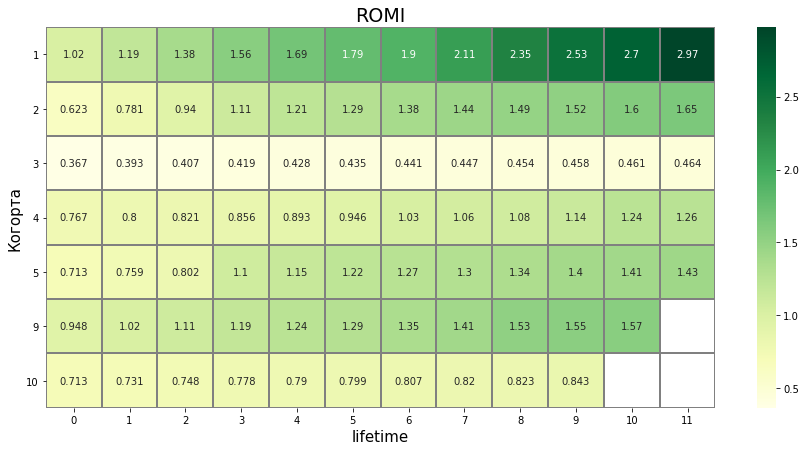

In [94]:
plt.figure(figsize=(15,7))
sns.heatmap(result_new, annot=True, fmt='.3', linewidths=1, linecolor='gray', cmap='YlGn')
plt.title('ROMI', fontsize=19)
plt.xlabel('lifetime', fontsize=15)
plt.ylabel('Когорта', fontsize=15)
plt.yticks(rotation=0, fontsize=10)

plt.show()

## Выводы и рекомендации

### Источники трафика

В первую очередь нужно обратить внимание на источник трафика 1, он окупился в первый же месяц и на всем протяжении жизни когорты показывал хорошие результаты, хотя суммарные траты на него невелики.  
Также неплохо себя показал источник 9, он окупился на второй месяц.  
Источники 5 и 2 окупились на 4й месяц.
Стоит отказаться от источника 3 и 10, так как траты на них высокие, а окупаемость слабая.

### Метрики

#### Продуктовые метрики

При расчете и визуализации метрик активных пользователей было обнаружено аномальное их увеличение в период второй половины ноября, что может быть связано с наступлением нового года. Увеличивается количество проводимых мероприятий, соответственно растет к ним интерес. Также возможно, что компании покупают билеты на мероприятия в качестве подарка своим сотрудникам.  

Retention Rate невысокий и не превышает 9%. Люди неохотно возвращаются возможно потому, что не могут позволить себе частые посещения мероприятий из финансовых соображений.

#### Метрики электронной коммерции

Большинство посетителей уже знает зачем приходит и совершает покупку в течении часа после перехода на сайт, а половина вообще справляется за 10 минут.  
При расчете среднего количества покупок заметна небольшая разница по сезонам, в холодные времена года покупки увеличиваются, соответственно летом снижаются, когда люди уезжают в отпуск и предпочитают активный отдых на природе вместо посещения мероприятий.  

Средний чек в течении года не превышает 15 у.е. Но в конце ноября - в начале декабря значительно увеличивается. Это подтверждает то, что большое количество билетов покупается компаниями в качестве подарка. Так как на них приходятся покупки на большие суммы, которые увеличивают средний чек.

#### Маркетинговые метрики

Cредний CAC на одного покупателя для всего проекта: 8.24  
Выше этого значения показатели источников 3 и 2.  
Лучший показатель ROMI у источника 1 и у него одного средний LTV выше среднего CAC.

**От источников трафика номер 3 и 10 нужно отказаться, по источнику 4 оптимизировать и снизить расходы.    
Что касается помесячных когорт, то лучше всех себя показывает сентябрьская, что опять же связано с наступлением периода неблагоприятных погодных условий, приближением нового года и началом театрального сезона.  
На втором месте когорта июня, я предположу, что к ней относятся любители фестивалей и концертов. С наступлением лета они активно посещают фестивали под открытым небом, а с наступлением осени перебираются в концертные залы.**